In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('../img/AOI_2.png')
# img = cv.imread('../img/Fighter_3.jpg')
# img = cv.imread('../img/live_3.jpeg')
# img = cv.imread('../img/live_1.jpg')

# 轉換灰階, 濾波
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# blurred = cv.GaussianBlur(gray_img, (3, 3), 0)

# 設定顏色區間上下界
lowThreshold = [0]
highThreshold = [0]
# 響應大小(kernel size)參數為 apertureSize 預設(3,3)
kernel = [3]

In [2]:
win_w = 720
win_h = 360

def hsv_track_bar(lowThreshold, highThreshold, kernel, win_name):
    # 定義滑桿callback函式
    def on_trackbar_lower(value):
        lowThreshold[0] = value
        highThreshold[0] = max(value, highThreshold[0])
    def on_trackbar_upper(value):
        highThreshold[0] = value
        lowThreshold[0] = min(value, lowThreshold[0])
    def on_trackbar_kernel(value):
        if (value >= 3): kernel[0] = value
        if (value % 2 == 0): kernel[0] = value +1
        
    cv.namedWindow(win_name, cv.WINDOW_KEEPRATIO)
    cv.resizeWindow(win_name, win_w, win_h)
    
    # 創建HSV上下界滑桿
    cv.createTrackbar("lower\n", win_name, lowThreshold[0], 10000, on_trackbar_lower)
    cv.createTrackbar("upper\n", win_name, highThreshold[0], 10000, on_trackbar_upper)
    cv.createTrackbar("kernel\n", win_name, kernel[0], 7, on_trackbar_kernel)
    
def hsv_track_bar_update(lowThreshold, highThreshold, kernel, win_name):
    # 設定滑桿在視窗中的位置
    cv.setTrackbarPos("lower\n", win_name, lowThreshold[0])
    cv.setTrackbarPos("upper\n", win_name, highThreshold[0])
    cv.setTrackbarPos("kernel\n", win_name, kernel[0])

#### 自適應

In [9]:
# https://blog.csdn.net/WZZ18191171661/article/details/89762062
# https://pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

def auto_canny(img, sigma=0.4):

	gray_img = img.copy()
	
	# plot是去背後剩下的pixel
	plot = BG_remove(gray_img, sigma)

	if (plot[0] == -1): #判定沒有背景

		# compute the median of the single channel pixel intensities
		median_value = np.median(img)

		lowThreshold[0] = int(max(0, (1.0 - sigma) * median_value))
		highThreshold[0] = int(min(255, (1.0 + sigma) * median_value))

		# apply automatic Canny edge detection using the computed median
		# edged = cv.Canny(img, lowThreshold[0], highThreshold[0])

		print("*Canny:( median:{}, low:{}, upper{})\n".format(median_value,lowThreshold[0],highThreshold[0]))
		print("-------------------")

		# return the edged image
		# return edged
	return plot

# 可調 峰值區間 delta=0.075, 背景占比 expec_portion=0.33
def BG_remove(gray_img,sigma,delta=0.075, expec_portion=0.33):
	
	# 計算 0~255 pixel 分布
	pixel_count = [0]*256
	for row in gray_img:
		for col in row:
			pixel_count[col] = pixel_count[col] + 1

	# 數量最多的pixel值
	most_value = np.argmax(pixel_count)
	
	# 計算預期去除pixel區間
	del_low = int(max(0, (1.0 - delta) * most_value))
	del_upper = int(min(255, (1.0 + delta) * most_value))
	print("*Img:( most_pixel:{}, delete_low:{}, delete_upper{})".format(most_value,del_low,del_upper))
	
	# 總pixel數量
	total_pixel = gray_img.shape[0]*gray_img.shape[1]
	
	# 計算預期棄除pixel數量
	discard_mount = 0
	for value in range(del_low ,del_upper+1):
		discard_mount = discard_mount + pixel_count[value]
	
	# 預期棄除pixel數量占比
	discard_portion = discard_mount / total_pixel
	print("*Img:( total_pixel:{}, discard_mount:{}, BG_portion:{:.2f})".format(total_pixel,discard_mount,discard_portion))

	# 自定一個預期比例下限expec_portion，大於expec_portion時認定為有背景，繼續function，否則return
	if (discard_portion > expec_portion):
		print("--Find backbround")
	else:
		print("--backbround Notfound")
		return [-1]
	
	# pixel 排序
	img_sorted = gray_img.ravel()
	img_sorted.sort()

	# 找出背景區間
	del_index = [0]*2
	
	for index in range(len(img_sorted)):
		if ( del_low <= img_sorted[index] ):
			del_index[0] = index
			break
	for index in range(len(img_sorted)-1,-1,-1):
		if ( del_upper >= img_sorted[index] ):
			del_index[1] = index
			break

	# 丟棄背景數據
	remian = np.append(img_sorted[:del_index[0]] ,img_sorted[del_index[1]:])
	print(img_sorted[del_index[0]], img_sorted[del_index[0]+1],img_sorted[del_index[1]-1],img_sorted[del_index[1]])
	# plt.hist(img_sorted, 256, [0, 256],label= 'background removed')
	# plt.hist(remian, 256, [0, 256],label= 'remain')
	# plt.legend()

	# 用中值擴展區間
	median_value = np.median(remian)
	lowThreshold[0] = int(max(0, (1.0 - sigma) * median_value))
	highThreshold[0] = int(min(255, (1.0 + sigma) * median_value))

	print("*Canny:( median:{}, low:{}, upper{})".format(median_value,lowThreshold[0],highThreshold[0]))
	print("-------------------")
	return remian


*Img:( most_pixel:201, delete_low:185, delete_upper216)
*Img:( total_pixel:1048576, discard_mount:744229, BG_portion:0.71)
--Find backbround
185 185 216 216
*Canny:( median:155.0, low:93, upper217)
-------------------
*Img:( most_pixel:199, delete_low:184, delete_upper213)
*Img:( total_pixel:534982, discard_mount:261375, BG_portion:0.49)
--Find backbround
184 184 211 211
*Canny:( median:149.0, low:89, upper208)
-------------------
去背


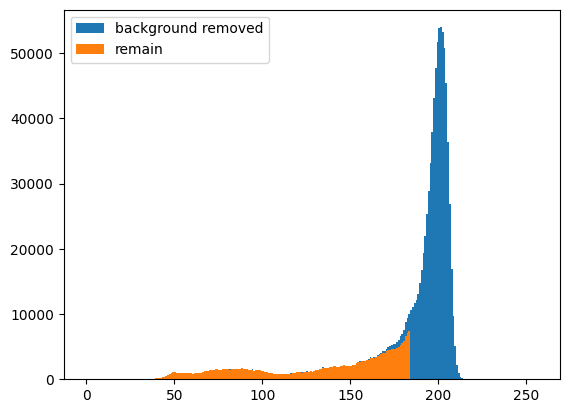

In [15]:
### main
# 視窗名稱
win_name = 'Canny'
# 建立滑桿
hsv_track_bar(lowThreshold, highThreshold, kernel, win_name)
# 自適應找上下限
plot = auto_canny(gray_img)
# canny成像
canny_auto = cv.Canny(gray_img, lowThreshold[0], highThreshold[0])

# 不斷獲取滑桿數值並更新影像
while True:
    # 同步滑桿數值
    hsv_track_bar_update(lowThreshold, highThreshold, kernel, win_name)
    
    # 自調參數
    canny_img = cv.Canny(gray_img, lowThreshold[0], highThreshold[0], apertureSize=kernel[0]) 

    # 顯示影像
    result_img = cv.hconcat([canny_img, gray_img, canny_auto])
    cv.imshow(win_name, result_img)
    
    keyboard = cv.waitKey(1)
    # 按下esc結束
    if keyboard == 27:
        break
    # q鍵使用框選
    if keyboard == ord('q'):
        cv.resizeWindow(win_name, win_w, int(win_h*1.5))
        
        # 滑鼠框選區域
        select_data = cv.selectROI(win_name, gray_img)
        img_cut = gray_img[select_data[1]:select_data[1]+select_data[3],select_data[0]:select_data[0]+select_data[2]]
        
        # 自適應找上下限
        plot = auto_canny(img_cut)
        # canny成像
        canny_auto = cv.Canny(gray_img, lowThreshold[0], highThreshold[0]) 
        
        cv.resizeWindow(win_name, win_w, win_h)

# 關閉所有視窗
cv.destroyAllWindows()

# plot image histogram
if (plot[0] != -1):
    print("去背")
    plt.hist(gray_img.ravel(), 256, [0, 256],label= 'background removed')
    plt.hist(plot, 256, [0, 256],label= 'remain')
    plt.legend()
else:
    plt.hist(gray_img.ravel(), 256, [0, 255],label= 'original image')
    plt.legend()